In [1]:
!pip install feedparser pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.2 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=0a31b59522e7c0baa37c3b4161050dcf6c2c97b99236d36d1414a5a3552b46f2
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [2]:
!pip install transformers

In [3]:
import feedparser
import pandas as pd
from datetime import datetime


In [4]:
rss_feeds = [
    'https://www.theage.com.au/rss/national/victoria.xml',
    'https://www.9news.com.au/rss',
    'https://www.theguardian.com/rss',
    'https://7news.com.au/feed'
]


Parse the RSS Fees

In [5]:
#Define a function to parse each feed and extract relevant information
def parse_rss(feed_url):
    feed = feedparser.parse(feed_url)
    articles = []

    for entry in feed.entries:
        article = {
            'title': entry.get('title', ''),
            'link': entry.get('link', ''),
            'published': entry.get('published', ''),
            'description': entry.get('description', entry.get('summary', '')),  # Extract description if available, otherwise use summary
            'source': feed.feed.get('title', 'Unknown Source')
        }
        articles.append(article)

    return articles


In [6]:
#Loop through each RSS feed, parse it, and collect all articles
all_articles = []

for feed_url in rss_feeds:
    print(f"Parsing feed: {feed_url}")
    articles = parse_rss(feed_url)
    all_articles.extend(articles)

print(f"Total articles fetched: {len(all_articles)}")


Parsing feed: https://www.theage.com.au/rss/national/victoria.xml
Parsing feed: https://www.9news.com.au/rss
Parsing feed: https://www.theguardian.com/rss
Parsing feed: https://7news.com.au/feed
Total articles fetched: 253


In [7]:
#Organize the collected data into a structured format using pandas.

df = pd.DataFrame(all_articles)

# Optional: Convert published date to datetime object
df['published'] = pd.to_datetime(df['published'], errors='coerce')

# Display the first few rows
print(df.head())


                                               title  \
0  Which is the coldest month in Melbourne? Take ...   
1  Leaders’ sledges, slurs and the decline of dec...   
2  A global conwoman’s wild lies and the victims ...   
3    The Age dominates Walkley Awards finalists list   
4  Woman fighting for life after dog attack in Me...   

                                                link  \
0  https://www.theage.com.au/national/victoria/wh...   
1  https://www.theage.com.au/national/victoria/le...   
2  https://www.theage.com.au/national/victoria/a-...   
3  https://www.theage.com.au/national/victoria/th...   
4  https://www.theage.com.au/national/victoria/wo...   

                   published  \
0  2024-10-11 05:00:00+11:00   
1  2024-10-10 20:00:00+11:00   
2  2024-10-10 19:05:32+11:00   
3  2024-10-10 18:31:00+11:00   
4  2024-10-10 18:27:05+11:00   

                                         description  \
0  How well do you know Melbourne and Victoria? T...   
1  Readers debate Can

<ipython-input-7-9116eca2e158>:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['published'] = pd.to_datetime(df['published'], errors='coerce')


In [8]:
# Save to CSV
df.to_csv('melbourne_news.csv', index=False)
print("Data saved to melbourne_news.csv")


Data saved to melbourne_news.csv


2. Text Preprocessing

In [9]:
#Loading and Inspecting the Data

import pandas as pd

# Load the saved CSV file
df = pd.read_csv('melbourne_news.csv')

# Inspect the first few rows
print(df.head())


                                               title  \
0  Which is the coldest month in Melbourne? Take ...   
1  Leaders’ sledges, slurs and the decline of dec...   
2  A global conwoman’s wild lies and the victims ...   
3    The Age dominates Walkley Awards finalists list   
4  Woman fighting for life after dog attack in Me...   

                                                link  \
0  https://www.theage.com.au/national/victoria/wh...   
1  https://www.theage.com.au/national/victoria/le...   
2  https://www.theage.com.au/national/victoria/a-...   
3  https://www.theage.com.au/national/victoria/th...   
4  https://www.theage.com.au/national/victoria/wo...   

                   published  \
0  2024-10-11 05:00:00+11:00   
1  2024-10-10 20:00:00+11:00   
2  2024-10-10 19:05:32+11:00   
3  2024-10-10 18:31:00+11:00   
4  2024-10-10 18:27:05+11:00   

                                         description  \
0  How well do you know Melbourne and Victoria? T...   
1  Readers debate Can

In [10]:
# Check for missing values
print(df.isnull().sum())

#fill missing values
df = df.fillna('Unknown')

title            0
link             0
published      217
description      0
source           0
dtype: int64


In [11]:
# Remove duplicate rows based on the 'title' or 'link'
df = df.drop_duplicates(subset='title', keep='first')

In [12]:
# Selecting only relevant columns
df = df[['title', 'description', 'link']]


In [13]:
import re

# Function to clean the text
def clean_text(text):
    # Remove HTML tags and URLs
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove non-alphanumeric characters and lower-case the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

# Apply the cleaning function to the description
df['cleaned_description'] = df['description'].apply(clean_text)


In [14]:
df.to_csv('cleaned_news_data.csv', index=False)


Categorizing Data with LLM

In [ ]:
from transformers import pipeline

# Load the zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate labels for your task
candidate_labels = ['violent crime', 'accident', 'other']

# Classify an example text
example_text = "A robbery occurred in Melbourne last night involving multiple suspects."
result = classifier(example_text, candidate_labels)

# Print the results
print(result)


In [ ]:
df = pd.read_csv('cleaned_news_data.csv')
df['category'] = df['cleaned_description'].apply(lambda x: classifier(x, candidate_labels)['labels'][0])


In [ ]:
df.to_csv('categorized_news_data.csv', index=False)

Zero shot Classification using DeBERTa

In [ ]:
from transformers import pipeline

# Load the DeBERTa-based classification model
classifier = pipeline("zero-shot-classification", model="microsoft/deberta-v3-large")

# Define candidate labels for your task
candidate_labels = ['violent crime', 'accident', 'other']

# Classify an example text
example_text = "A robbery occurred in Melbourne last night involving multiple suspects."
result = classifier(example_text, candidate_labels)

# Print the results
print(result)


In [ ]:
# Apply the classifier to your DataFrame
df = pd.read_csv('cleaned_news_data.csv')
df['category'] = df['cleaned_description'].apply(lambda x: classifier(x, candidate_labels)['labels'][0])

In [ ]:
df.to_csv('categorized_news_data_deberta.csv', index=False)

Zero Shot classification using T5 model


In [ ]:
from transformers import pipeline

# Load the T5-based classification model (ensure you use a fine-tuned version for classification tasks)
classifier = pipeline("zero-shot-classification", model="valhalla/t5-base-qa-qg-hl")

# Define candidate labels for your task
candidate_labels = ['violent crime', 'accident', 'other']

# Classify an example text
example_text = "A robbery occurred in Melbourne last night involving multiple suspects."
result = classifier(example_text, candidate_labels)

# Print the results
print(result)


In [ ]:
# Apply the classifier to your DataFrame
df = pd.read_csv('cleaned_news_data.csv')
df['category'] = df['cleaned_description'].apply(lambda x: classifier(x, candidate_labels)['labels'][0])

In [ ]:
df.to_csv('categorized_news_data_t5.csv', index=False)

Extractiing Crime and Accident Location

In [ ]:
!pip install beautifulsoup4 requests

In [ ]:
#Scraping news articles from URL with crime or accident news

import requests
from bs4 import BeautifulSoup

# Load the CSV file with the categorized news data
df = pd.read_csv('categorized_news_data.csv')

# Function to scrape full article from URL
def scrape_full_article(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the main article content (depends on the website structure)
        article_text = " ".join([p.get_text() for p in soup.find_all('p')])
        return article_text
    except Exception as e:
        return None

# Scrape only articles labeled 'crime' or 'accident'
for index, row in df.iterrows():
    if row['category'] in ['violent crime', 'accident']:
        full_article_text = scrape_full_article(row['link'])
        df.at[index, 'full_text'] = full_article_text


In [ ]:
#Using NER to extract location of crime and accidents

from transformers import pipeline

# Load pre-trained NER model from Hugging Face
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

# Function to extract locations using Hugging Face NER
def extract_location_with_bert(text):
    entities = ner_pipeline(text)
    locations = [entity['word'] for entity in entities if entity['entity_group'] == "LOC"]  # LOC represents locations
    return locations

# Create 'locations' column if it doesn't exist
if 'locations' not in df.columns:
    df['locations'] = None

# Apply the NER model to the full text
for index, row in df.iterrows():
    if row['category'] in ['crime', 'accident'] and pd.notna(row['full_text']):
        locations = extract_location_with_bert(row['full_text'])
        df.at[index, 'locations'] = locations



In [ ]:
df.to_csv('location_news_data.csv', index=False)

In [ ]:
# Load the CSV file with the loacions news data
df = pd.read_csv('location_news_data.csv')
df.head()

In [ ]:
#define locations using OpenAssistant/oasst-sft-1-pythia-12b

from transformers import pipeline

# Load OpenAssistant model for text generation (dialogue/refinement)
oasst_model = pipeline("text-generation", model="OpenAssistant/oasst-sft-1-pythia-12b")

# Define a function to refine extracted locations
def refine_locations(ner_locations, full_text):
    if not ner_locations:
        return None

    # Prepare the input prompt for OpenAssistant
    prompt = f"In the following article, the locations {ner_locations} were mentioned. Which location is most likely the site of the crime or accident? Here is the article text:\n\n{full_text}"

    # Get refined location from the OpenAssistant model
    response = oasst_model(prompt, max_length=200, do_sample=False)[0]['generated_text']

    # Extract the location mentioned in the response (we assume it returns one or two relevant locations)
    refined_location = response.strip()
    return refined_location

# Apply the refinement to the DataFrame
df['refined_location'] = df.apply(lambda row: refine_locations(row['locations'], row['full_text']), axis=1)


Locating on Map

In [ ]:
!pip install geopandas folium geopy

In [ ]:
import pandas as pd
import ast

# Load the CSV file with the locations news data
df = pd.read_csv('location_news_data.csv')

# Initialize an empty list to hold the new rows
extracted_data = []

# Filter out rows with NaN or empty lists in the 'locations' column
filtered_df = df[df['locations'].notna() & (df['locations'].astype(str) != '[]')]

# Iterate over the filtered DataFrame
for index, row in filtered_df.iterrows():
    locations = row['locations']  # Get the list of locations
    category = row['category']  # Get the corresponding category

    # Convert string representation of list to actual list if it's a string
    if isinstance(locations, str):
        try:
            locations = ast.literal_eval(locations)  # Safely evaluate string representation of a list
        except (ValueError, SyntaxError):
            locations = []  # Handle any errors by setting to an empty list

    # Check if locations is a list
    if isinstance(locations, list):
        # Iterate over the list of locations
        for loc in locations:
            extracted_data.append({
                'category': category,
                'location': loc.strip()  # Clean any whitespace
            })

# Create a new DataFrame from the extracted data
extracted_df = pd.DataFrame(extracted_data)

# Optionally, drop duplicates if needed
extracted_df.drop_duplicates(inplace=True)

# Show the resulting DataFrame
print(extracted_df)

# Save to CSV
extracted_df.to_csv('extracted_locations.csv', index=False)


    category              location
0   accident             Australia
1   accident            Naked City
2   accident                Greece
4   accident                Athens
9   accident                  Rome
11  accident                    UK
12  accident               Britain
13  accident             Melbourne
15  accident                 Italy
19  accident                     −
20  accident                Sydney
23  accident                 Spain
24  accident               Germany
25  accident                 Saira
27  accident                Haniya
28  accident                Zurich
29  accident                London
30  accident                Barnet
32  accident        Czechoslovakia
33  accident                 Spiel
34  accident               Chvátil
35  accident           Spellenhuis
36  accident                    LA
40  accident              Penelope
41  accident                Madden
42  accident                Venice
43  accident              Trinidad
47  accident        

In [ ]:
df.head()

,title,description,link,cleaned_description,category,full_text,locations,suburb,latitude,longitude
0,"‘When my time’s up, my time’s up’: How Sam ‘Th...","The boxer and ex-bikie has survived shootings,...",https://www.theage.com.au/national/victoria/wh...,the boxer and exbikie has survived shootings b...,voilent crime,NaN,NaN,None,None,None
1,How a rule tweak left hundreds of thousands of...,"Under a controversial council election change,...",https://www.theage.com.au/national/victoria/ho...,under a controversial council election change ...,political,NaN,NaN,None,None,None
2,Who won the 2024 Brownlow Medal? Take The Age ...,How well do you know Melbourne and Victoria? T...,https://www.theage.com.au/national/victoria/wh...,how well do you know melbourne and victoria te...,political,NaN,NaN,None,None,None
3,Peter Dutton’s tactics of distraction and divi...,Readers respond to Peter Dutton’s tactics of d...,https://www.theage.com.au/national/victoria/pe...,readers respond to peter duttons tactics of di...,political,NaN,NaN,None,None,None
4,"Easey Street’s sliding doors moment, and the s...",Detectives work on facts but every now and aga...,https://www.theage.com.au/national/victoria/ea...,detectives work on facts but every now and aga...,accident,"We’re sorry, this feature is currently unavail...","['Australia', '##asey Street', 'Collingwood', ...",None,None,None


Trying classification with clustering techniques

In [ ]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 12.7 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


News articles clustered and saved to 'clustered_news.csv'


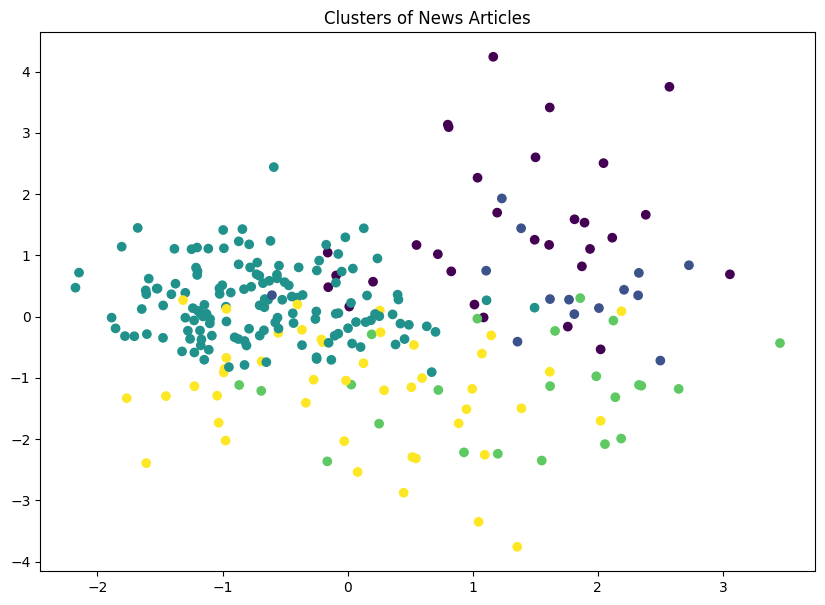

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the CSV file with the cleaned and normalized text
df = pd.read_csv('cleaned_news_data.csv')

# Initialize sentence-transformer for embedding text data
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Convert news descriptions into embeddings
embeddings = model.encode(df['normalized_description'].tolist())

# Perform K-Means clustering
num_clusters = 5  # You can change the number of clusters based on your preference
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
df['cluster'] = kmeans.fit_predict(embeddings)

# Save the results to a new CSV file
df.to_csv('clustered_news.csv', index=False)
print("News articles clustered and saved to 'clustered_news.csv'")

# Optional: Visualize the clusters using PCA (for dimensionality reduction)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster'], cmap='viridis')
plt.title('Clusters of News Articles')
plt.show()


Elbow Method for Finding Optimal Clusters:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

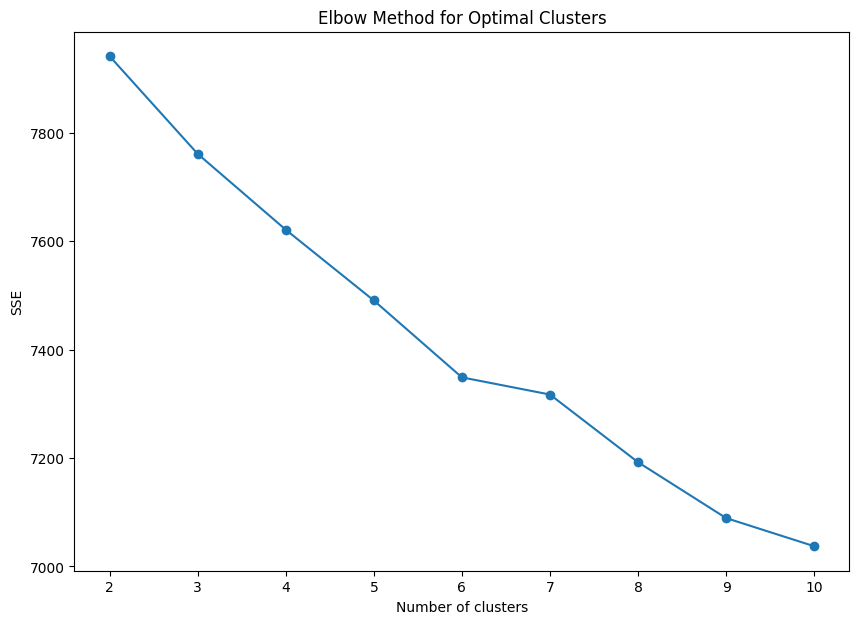

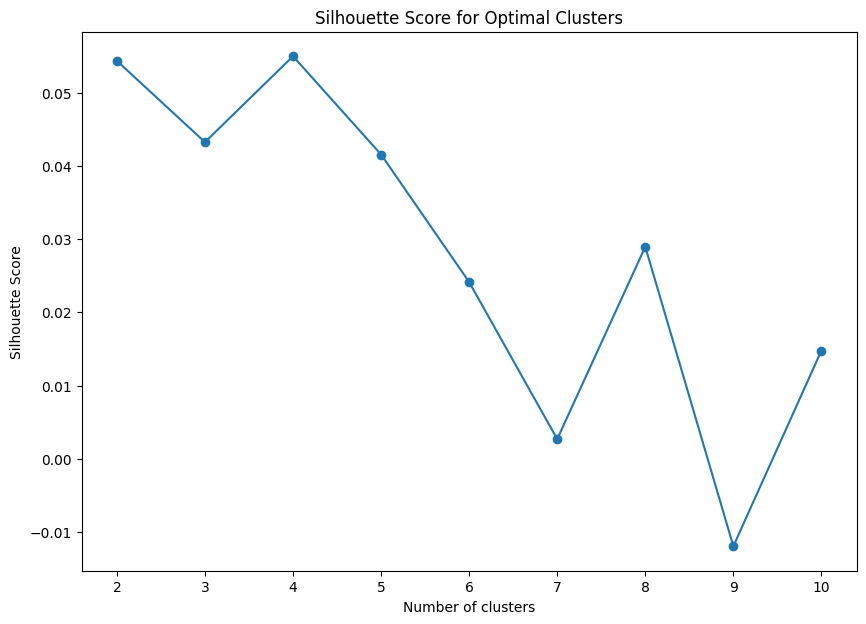

In [ ]:
from sklearn.metrics import silhouette_score

def find_optimal_clusters(embeddings, max_k):
    iters = range(2, max_k+1)
    sse = []
    silhouette_scores = []

    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)  # Sum of squared distances
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    plt.figure(figsize=(10, 7))
    plt.plot(iters, sse, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.plot(iters, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

# Run the Elbow Method to find the optimal number of clusters
find_optimal_clusters(embeddings, 10)


One Shot Classification Using BERT

In [ ]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
import openai
import pandas as pd

# Load your CSV file with news descriptions
df = pd.read_csv('cleaned_news_data.csv')

# Define your categories for classification
categories = ['Crime', 'Government', 'Business', 'violence', 'Science', 'Culture']

# Initialize OpenAI API
openai.api_key = ""

# Function to generate GPT-3 prompt for zero-shot classification
def classify_article_with_gpt3(article, categories):
    prompt = f"Classify the following news article into one of these categories: {', '.join(categories)}.\n\nArticle: {article}\n\nCategory:"

    response = openai.Completion.create(
        engine="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        prompt=prompt,
        max_tokens=10,
        n=1,
        stop=None,
        temperature=0  # Lower temperature for deterministic output
    )

    category = response.choices[0].text.strip()
    return category

# Apply classification on each article
df['gpt3_category'] = df['normalized_description'].apply(lambda x: classify_article_with_gpt3(x, categories))

# Save the results to CSV
df.to_csv('gpt3_classified_news.csv', index=False)
print("GPT-3 classification complete. Results saved to 'gpt3_classified_news.csv'")


APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
